**PREDECTING HOUSING PRICE PROJECT**

THIS DATA REPRESENTS INFORMATION ABOUT HOUSES IN MULTIPLE PLACES, FEATURES ARE: TOTAL ROOMS OF ALL HOUSES OF CERTAIN PLACE, TOTAL BEDROOMS TOO, POPULATION, HOUSEHOLDS AND MEDIAN INCOME. THE TARGET IS MEDIAN OF PRICE OF HOUSES. SO, I WILL USE REGRESSION LEARNING TO PREDICT THE TARGET. THE DATA IS TOO BIG BUT IT WORTH THE EFFORT FOR SURE.

# Libraries

In [157]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score, root_mean_squared_error, mean_absolute_error

# Explore Data

In [158]:
df = pd.read_csv(r'C:\Users\PCCV\OneDrive\Desktop\ML Python\Basics Py\housing.csv')
df.head(10)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,-122.23,37.88,41,880,129.0,322,126,8.3252,452600
1,-122.22,37.86,21,7099,1106.0,2401,1138,8.3014,358500
2,-122.24,37.85,52,1467,190.0,496,177,7.2574,352100
3,-122.25,37.85,52,1274,235.0,558,219,5.6431,341300
4,-122.25,37.85,52,1627,280.0,565,259,3.8462,342200
5,-122.25,37.85,52,919,213.0,413,193,4.0368,269700
6,-122.25,37.84,52,2535,489.0,1094,514,3.6591,299200
7,-122.25,37.84,52,3104,687.0,1157,647,3.1200,241400
8,-122.26,37.84,42,2555,665.0,1206,595,2.0804,226700
9,-122.25,37.84,52,3549,707.0,1551,714,3.6912,261100


In [159]:
df.shape

(20640, 9)

In [160]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  int64  
 3   total_rooms         20640 non-null  int64  
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  int64  
 6   households          20640 non-null  int64  
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  int64  
dtypes: float64(4), int64(5)
memory usage: 1.4 MB


In [161]:
df.isnull().sum() # there is a nan!

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
dtype: int64

In [162]:
df.dropna(subset=["total_bedrooms"], inplace=True)  # eliminating nan

In [163]:
df.isnull().sum()

longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
dtype: int64

In [164]:
df.shape # nan removed!

(20433, 9)

In [165]:
df.duplicated().sum() # no duplicates

np.int64(0)

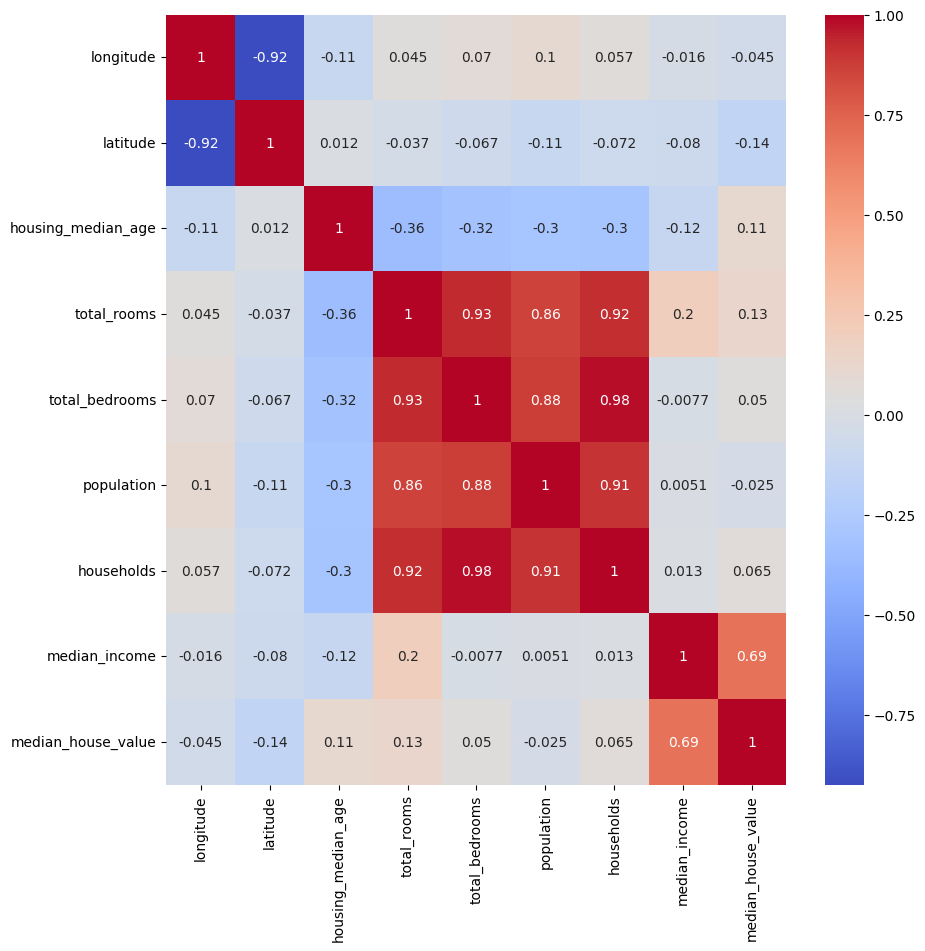

In [166]:
correlation = df.corr()
plt.figure(figsize=(10,10))
sns.heatmap(correlation, annot=True, cmap='coolwarm')
plt.show() # relations are important for regression

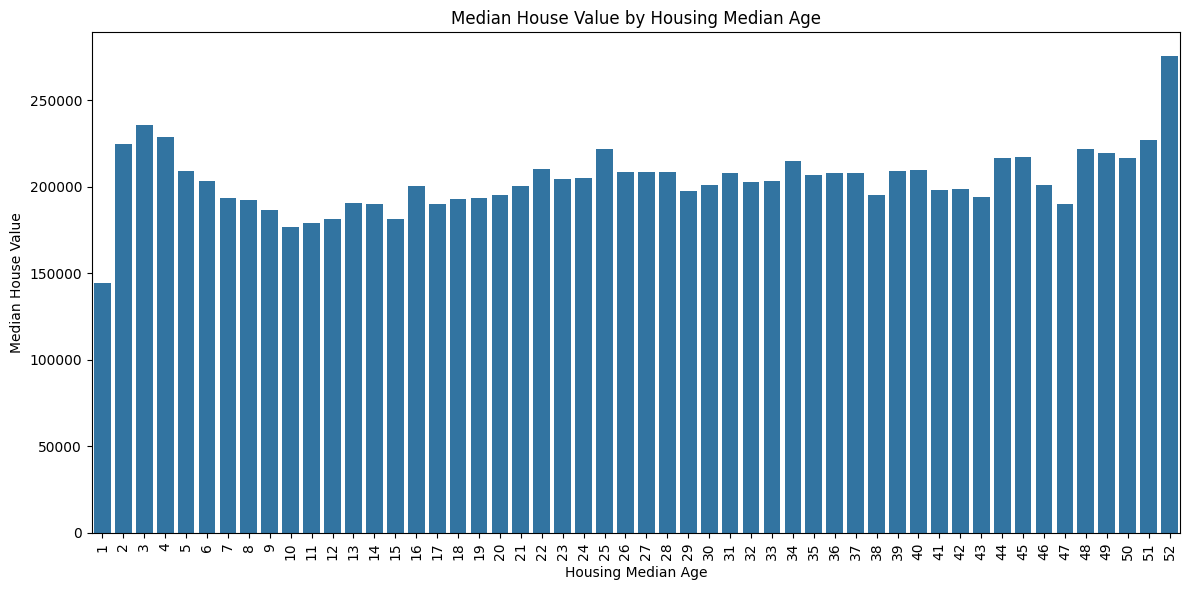

In [167]:
# Group by housing_median_age and calculate the mean of median_house_value
age_value = df.groupby('housing_median_age')['median_house_value'].mean().reset_index()
plt.figure(figsize=(12, 6))
sns.barplot(x='housing_median_age', y='median_house_value', data=age_value)
plt.title('Median House Value by Housing Median Age')
plt.xlabel('Housing Median Age')
plt.ylabel('Median House Value')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Preprocessing & Model Selection

In [ ]:
x = df.drop('median_house_value', axis=1)
y = df['median_house_value']

In [169]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.15, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=42)

In [170]:
# random forest regressor
forest_pipeline = Pipeline([
    ('scale', StandardScaler()),
    ('forest', RandomForestRegressor(random_state=42))
])

# gradient boost method
gradient_boosting_pipeline = Pipeline([
    ('scale', StandardScaler()),
    ('gradient_boosting', GradientBoostingRegressor(random_state=42))
])

# staking method
stacking_pipeline = Pipeline([
    ('scale', StandardScaler()),
    ('stacking', StackingRegressor(estimators=[
        ('knn', KNeighborsRegressor()),
        ('forest', RandomForestRegressor(random_state=42)),],
    final_estimator=LinearRegression()))
])

In [171]:
# random forest
forest_grid = {
    'forest__n_estimators': [50,70],
    'forest__max_depth': [10,12],
    'forest__min_samples_split': [2]
}

# gradient boost method
gradient_boosting_grid = {
    'gradient_boosting__n_estimators': [70,80],
    'gradient_boosting__learning_rate': [0.1],
    'gradient_boosting__max_depth': [7,9]
}

# staking method
stacking_pipeline_grid = {
    'stacking__knn__n_neighbors': [5],
    'stacking__forest__n_estimators': [50],
    'stacking__forest__max_depth': [10, 12],
    'stacking__final_estimator__fit_intercept': [True, False]
}

In [172]:
kfold = KFold(n_splits=7, shuffle=True, random_state=42) # i noticed that there is overfitting in random forest,stacking and gradient. it is better than stratified K in regresion

# Evaluation

In [173]:
# GridSearch for random forest Regressor
forest_grid_search = GridSearchCV(forest_pipeline, forest_grid, cv=kfold, n_jobs=-1)
forest_grid_search.fit(x_train, y_train)
print("Best parameters for random forest Regressor:", forest_grid_search.best_params_)
print("Best R2 score for random forest Regressor:", forest_grid_search.best_score_)

# GridSearch for Gradient Boosting
gradient_boosting_grid_search = GridSearchCV(gradient_boosting_pipeline, gradient_boosting_grid, cv=kfold, n_jobs=-1)
gradient_boosting_grid_search.fit(x_train, y_train)
print("Best parameters for Gradient Boosting:", gradient_boosting_grid_search.best_params_)
print("Best R2 score for Gradient Boosting:", gradient_boosting_grid_search.best_score_)

Best parameters for random forest Regressor: {'forest__max_depth': 12, 'forest__min_samples_split': 2, 'forest__n_estimators': 70}
Best R2 score for random forest Regressor: 0.8038963258621673
Best parameters for Gradient Boosting: {'gradient_boosting__learning_rate': 0.1, 'gradient_boosting__max_depth': 7, 'gradient_boosting__n_estimators': 80}
Best R2 score for Gradient Boosting: 0.8247643969148023


In [174]:
# GridSearch for stacking
stacking_grid_search = GridSearchCV(stacking_pipeline, stacking_pipeline_grid, cv=kfold, n_jobs=-1)
stacking_grid_search.fit(x_train, y_train)
print("Best parameters for Stacking:", stacking_grid_search.best_params_)
print("Best R2 score for Stacking:", stacking_grid_search.best_score_)

Best parameters for Stacking: {'stacking__final_estimator__fit_intercept': True, 'stacking__forest__max_depth': 12, 'stacking__forest__n_estimators': 50, 'stacking__knn__n_neighbors': 5}
Best R2 score for Stacking: 0.8059027279249458


In [175]:
# Evaluation of models
models = {
    "Random Forest": forest_grid_search.best_estimator_,
    "Gradient Boosting": gradient_boosting_grid_search.best_estimator_,
    "Stacking (KNN + Random Forest & Linear Reg.)": stacking_grid_search.best_estimator_
}

print(" Model Performance")
for name, model in models.items():
    y_train_pred = model.predict(x_train)
    y_val_pred = model.predict(x_val)
    y_test_pred = model.predict(x_test)

    r2_train = r2_score(y_train, y_train_pred)
    r2_val = r2_score(y_val, y_val_pred)
    r2_test = r2_score(y_test, y_test_pred)
    rmse_train = root_mean_squared_error(y_train, y_train_pred)
    rmse_val = root_mean_squared_error(y_val, y_val_pred)
    rmse_test = root_mean_squared_error(y_test, y_test_pred)
    mae_train = mean_absolute_error(y_train, y_train_pred)
    mae_val = mean_absolute_error(y_val, y_val_pred)
    mae_test = mean_absolute_error(y_test, y_test_pred)

    print(f"\n ----- {name} Performance ----- ")
    print(f"-> R2 Score for Train: {r2_train:.4f} || Validation: {r2_val:.4f} || Test: {r2_test:.4f}")
    print(f"-> RMSE for Train: {rmse_train:.2f} || Validation: {rmse_val:.2f} || Test: {rmse_test:.2f}")
    print(f"-> MAE for Train: {mae_train:.2f} || Validation: {mae_val:.2f} || Test: {mae_test:.2f}")

 Model Performance

 ----- Random Forest Performance ----- 
-> R2 Score for Train: 0.9171 || Validation: 0.7904 || Test: 0.8032
-> RMSE for Train: 33250.50 || Validation: 51646.78 || Test: 51791.37
-> MAE for Train: 23130.55 || Validation: 33618.59 || Test: 34286.90

 ----- Gradient Boosting Performance ----- 
-> R2 Score for Train: 0.9175 || Validation: 0.8093 || Test: 0.8219
-> RMSE for Train: 33163.41 || Validation: 49255.75 || Test: 49273.10
-> MAE for Train: 23414.82 || Validation: 31784.01 || Test: 32823.08

 ----- Stacking (KNN + Random Forest & Linear Reg.) Performance ----- 
-> R2 Score for Train: 0.9174 || Validation: 0.7912 || Test: 0.8064
-> RMSE for Train: 33180.78 || Validation: 51542.43 || Test: 51365.49
-> MAE for Train: 23041.77 || Validation: 33433.91 || Test: 33823.60


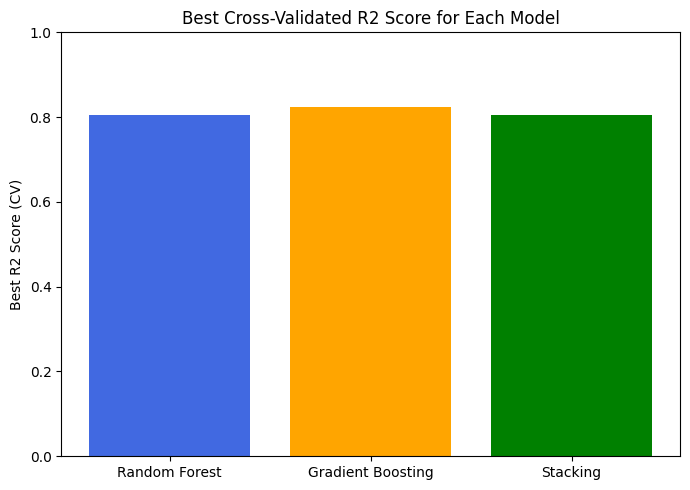

In [176]:
# bar plot for comparing best r2 score between models
model_names = ["Random Forest", "Gradient Boosting", "Stacking"]
best_r2_scores = [
    forest_grid_search.best_score_,
    gradient_boosting_grid_search.best_score_,
    stacking_grid_search.best_score_
]

x = np.arange(len(model_names)) 
plt.figure(figsize=(7, 5))
plt.bar(x, best_r2_scores, color=['royalblue', 'orange', 'green'])
plt.xticks(x, model_names)
plt.ylabel('Best R2 Score (CV)')
plt.title('Best Cross-Validated R2 Score for Each Model')
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

WE SEE THAT GRADIENT BOOSTING HERE IS THE BEST ONE ACCORDING TO R2 SCORE,THE SECOND ONE IS STACKING,AND THE THIRD ONE IS RANDOM FOREST, BUT THERE IS NO BIG DIFFERENCE BETWEEN THEM.